# Spike sorting

Eduardo Blancas

## What is spike sorting?

![spike_sort](https://raw.githubusercontent.com/edublancas/neural-clustering/master/notebooks/static/spike-sort.jpg)

*Source: scholarpedia.org*


**Grouping** of spikes into clusters based on the **similarity of their shapes.** Given that, each neuron tends to fire spikes of a particular shape, the resulting clusters correspond to the activity of different neurons. The end result of spike sorting is the determination of which spike corresponds to which of these neurons. (Quiroga, 2007)

## Spike sorting pipeline

![pipeline](https://raw.githubusercontent.com/edublancas/neural-clustering/master/notebooks/static/pipeline.jpg)

*Source: scholarpedia.org*

## Why is it important?

Most projects involving analysis of neural data involve spike sorting as the first step, the analysis continues once the number of neurons and spike times have been determined.

## Scaling challenge in spike sorting

A crucial consideration going forward is the ability to scale to massive datasets – MEAs (Multiple Electrode Arrays) currently scale
up to the order of 10^4 electrodes, but efforts are underway to increase this number to 10^6 (Lee, 2017).

## Clustering

This projects focuses on the clustering step, once spikes have been detected, waveforms are extracted around the spike. Temporal dimensionality is reduced by using an autoencoder (31 to 3 dimensions), for this project we are considering all 7 spatial dimensions (one per channel) in the data, but we are currently working on scaling up clustering by only considering neighboring channels.

## Glossary

I will be specific vocabulary to refer to the data and the results:

* **Spike**: a point in time during the recordings where neuron activity is detected
* **Clear spike**: a clean spike (no collisions, low noise levels)
* **Waveform**: a small snippet around a spike time (whenever we detect a spike, we get the observations around it)
* **Template**: once clustering is done, we collect waveforms in every spike time, we average them channel by channel and construct a template


## References

Quiroga, R. (2007) Spike Sorting. http://www.scholarpedia.org/article/Spike_sorting

Lee, J. et al. (2017). YASS: Yet another spike sorter. Neural Information Processing Systems. Available in biorxiv: https://www.biorxiv.org/content/early/2017/06/19/151928

# Data loading

This notebook loads the raw data and the pre-processed files generated by the YASS library, we will use one of those files as input for the clustering algorithm.

In [2]:
%matplotlib inline

import logging
import os

import numpy as np

from yass.neuralnet import NeuralNetDetector
from yass.config import Config

from neural_clustering.explore import (SpikeTrainExplorer,
                                       RecordingExplorer)
from neural_clustering import config


import matplotlib.pyplot as plt

/Users/Edu/miniconda3/envs/test-project/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 10)

In [4]:
logging.basicConfig(level=logging.ERROR)

# Loading configuration files and YASS output

YASS is a Python package for spike sorting, which is being developed by Peter Lee (PhD in the Stats department and me): https://github.com/paninski-lab/yass

Someone in the lab implemented a truncated DPMM using numpy. Since the code is hard to debug and the only person who understands it is the person who wrote it, I want to see if we can start using Edward instead, so we can iterate quickly and prototype new models easily – without having to write custom inference algorithms every time.


In [5]:
# load configuration files
cfg_yass = Config.from_yaml('../yass_config/demo.yaml')
cfg = config.load('../config.yaml')

In [6]:
# load data generated from yass, we are only interested
# in spike_times and clear_index but we need to load all of them
# to instantiate the explorers that implement the functions we will
# use
files = ['score', 'clear_index', 'spike_times',
         'spike_train', 'spike_left', 'templates']

(score, clear_index,
 spike_times, spike_train,
 spike_left, templates) = [np.load(os.path.join(cfg['root'], 'yass/{}.npy'.format(f))) for f in  files]

# Loading raw recordings, geometry file and projection matrix

We load raw data, standarized data and channel geometry (spatial location of electrodes)

In [7]:
# load raw recordings
path_to_raw_recordings = os.path.join(cfg_yass.root, '7ch.bin')
# load standarized recordings (these are raw recordings + filter + standarization)
path_to_recordings = os.path.join(cfg_yass.root, 'tmp/standarized.bin')
# load gemetry file (position for every electro)
path_to_geometry = os.path.join(cfg_yass.root, cfg_yass.geomFile)

In [8]:
# load projection matrix (to reduce dimensionality)
proj = NeuralNetDetector(cfg_yass).load_w_ae()

# Initialize explorers

This helper classes contain functions to plot the data.

In [10]:
# initialize explorers, these objects implement functions for plotting
# the output from YASS
explorer_rec = RecordingExplorer(path_to_recordings,
                                 path_to_geometry,
                                 dtype='float64',
                                 window_size=cfg_yass.spikeSize,
                                 n_channels=cfg_yass.nChan,
                                 neighbor_radius=cfg_yass.spatialRadius)

explorer_raw = RecordingExplorer(path_to_raw_recordings,
                                 path_to_geometry,
                                 dtype='int16',
                                 window_size=cfg_yass.spikeSize,
                                 n_channels=cfg_yass.nChan,
                                 neighbor_radius=cfg_yass.spatialRadius)


explorer_train = SpikeTrainExplorer(templates,
                                    spike_train,
                                    explorer_rec,
                                    proj)

In [16]:
print('Observations: {}. Channels: {}'.format(*explorer_raw.data.shape))

Observations: 6000000. Channels: 7


# Raw recordings

The timeseries plot shows how the raw data looks like in every channel.

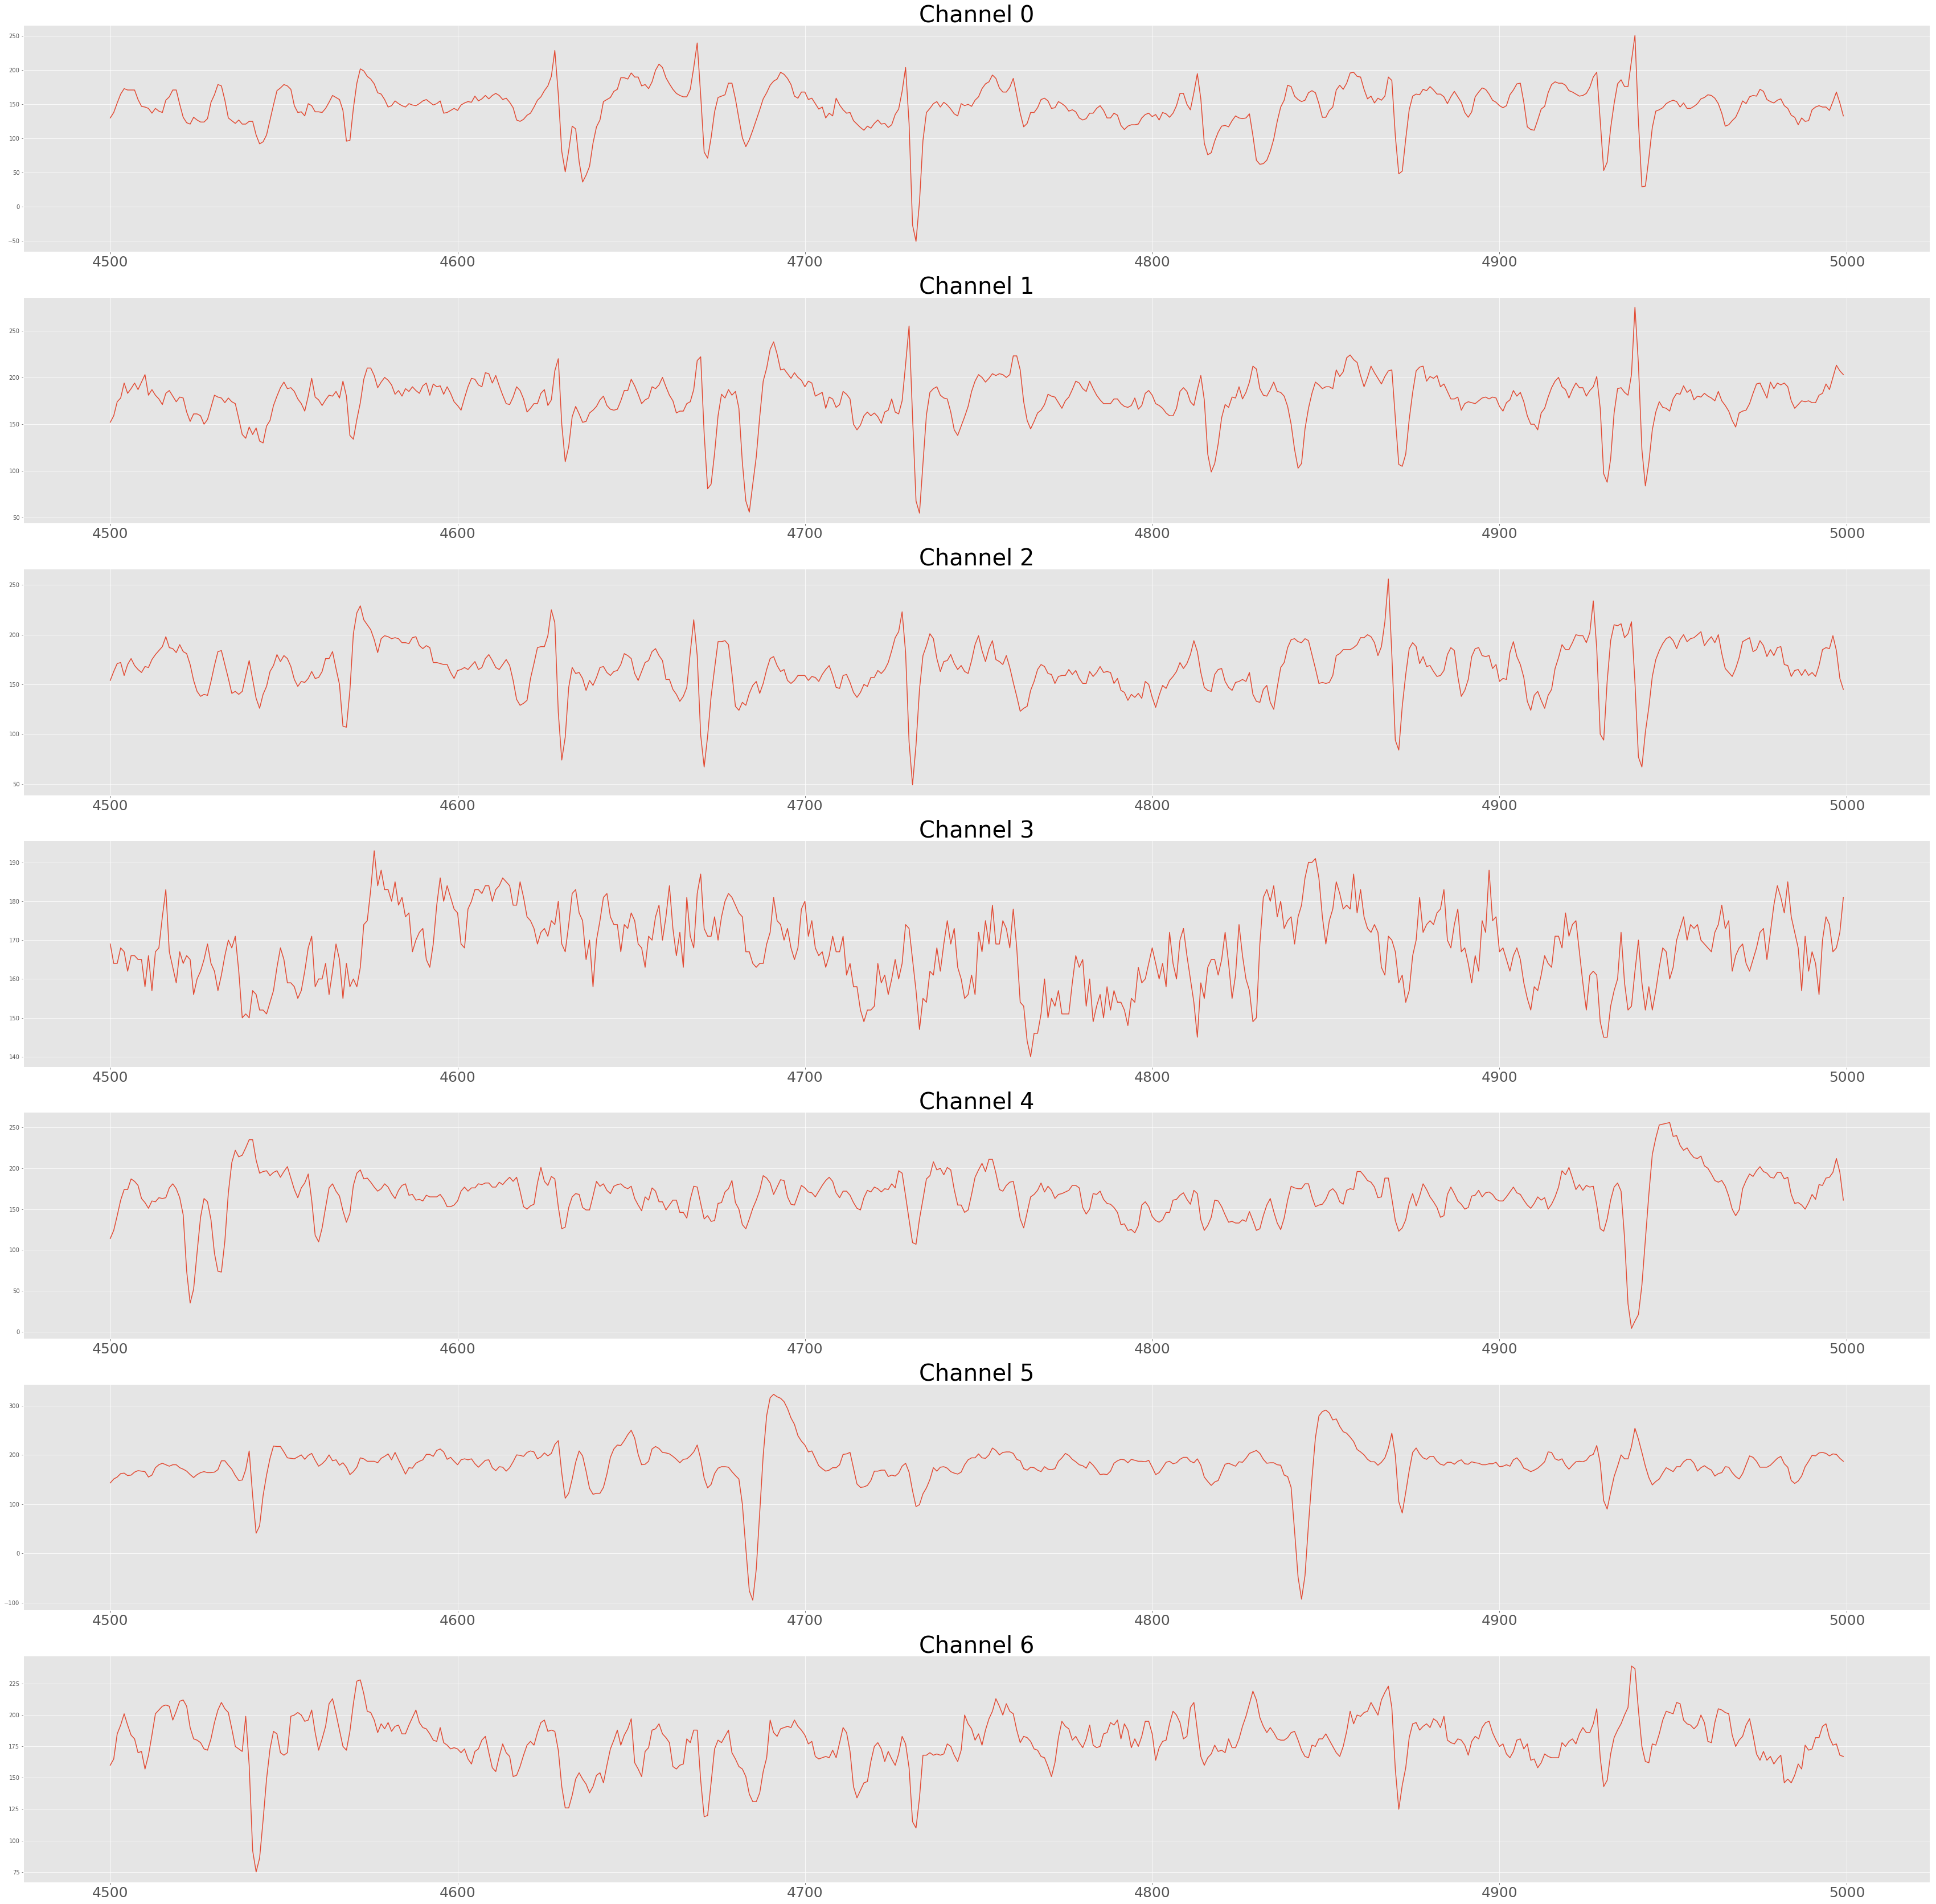

In [17]:
plt.rcParams['figure.figsize'] = (60, 60)
explorer_raw.plot_series(from_time=4500, to_time=5000)

## Filtered + Standarized Recordings

The timeseries plot shows how the filtered + standarized data looks like in every channel.

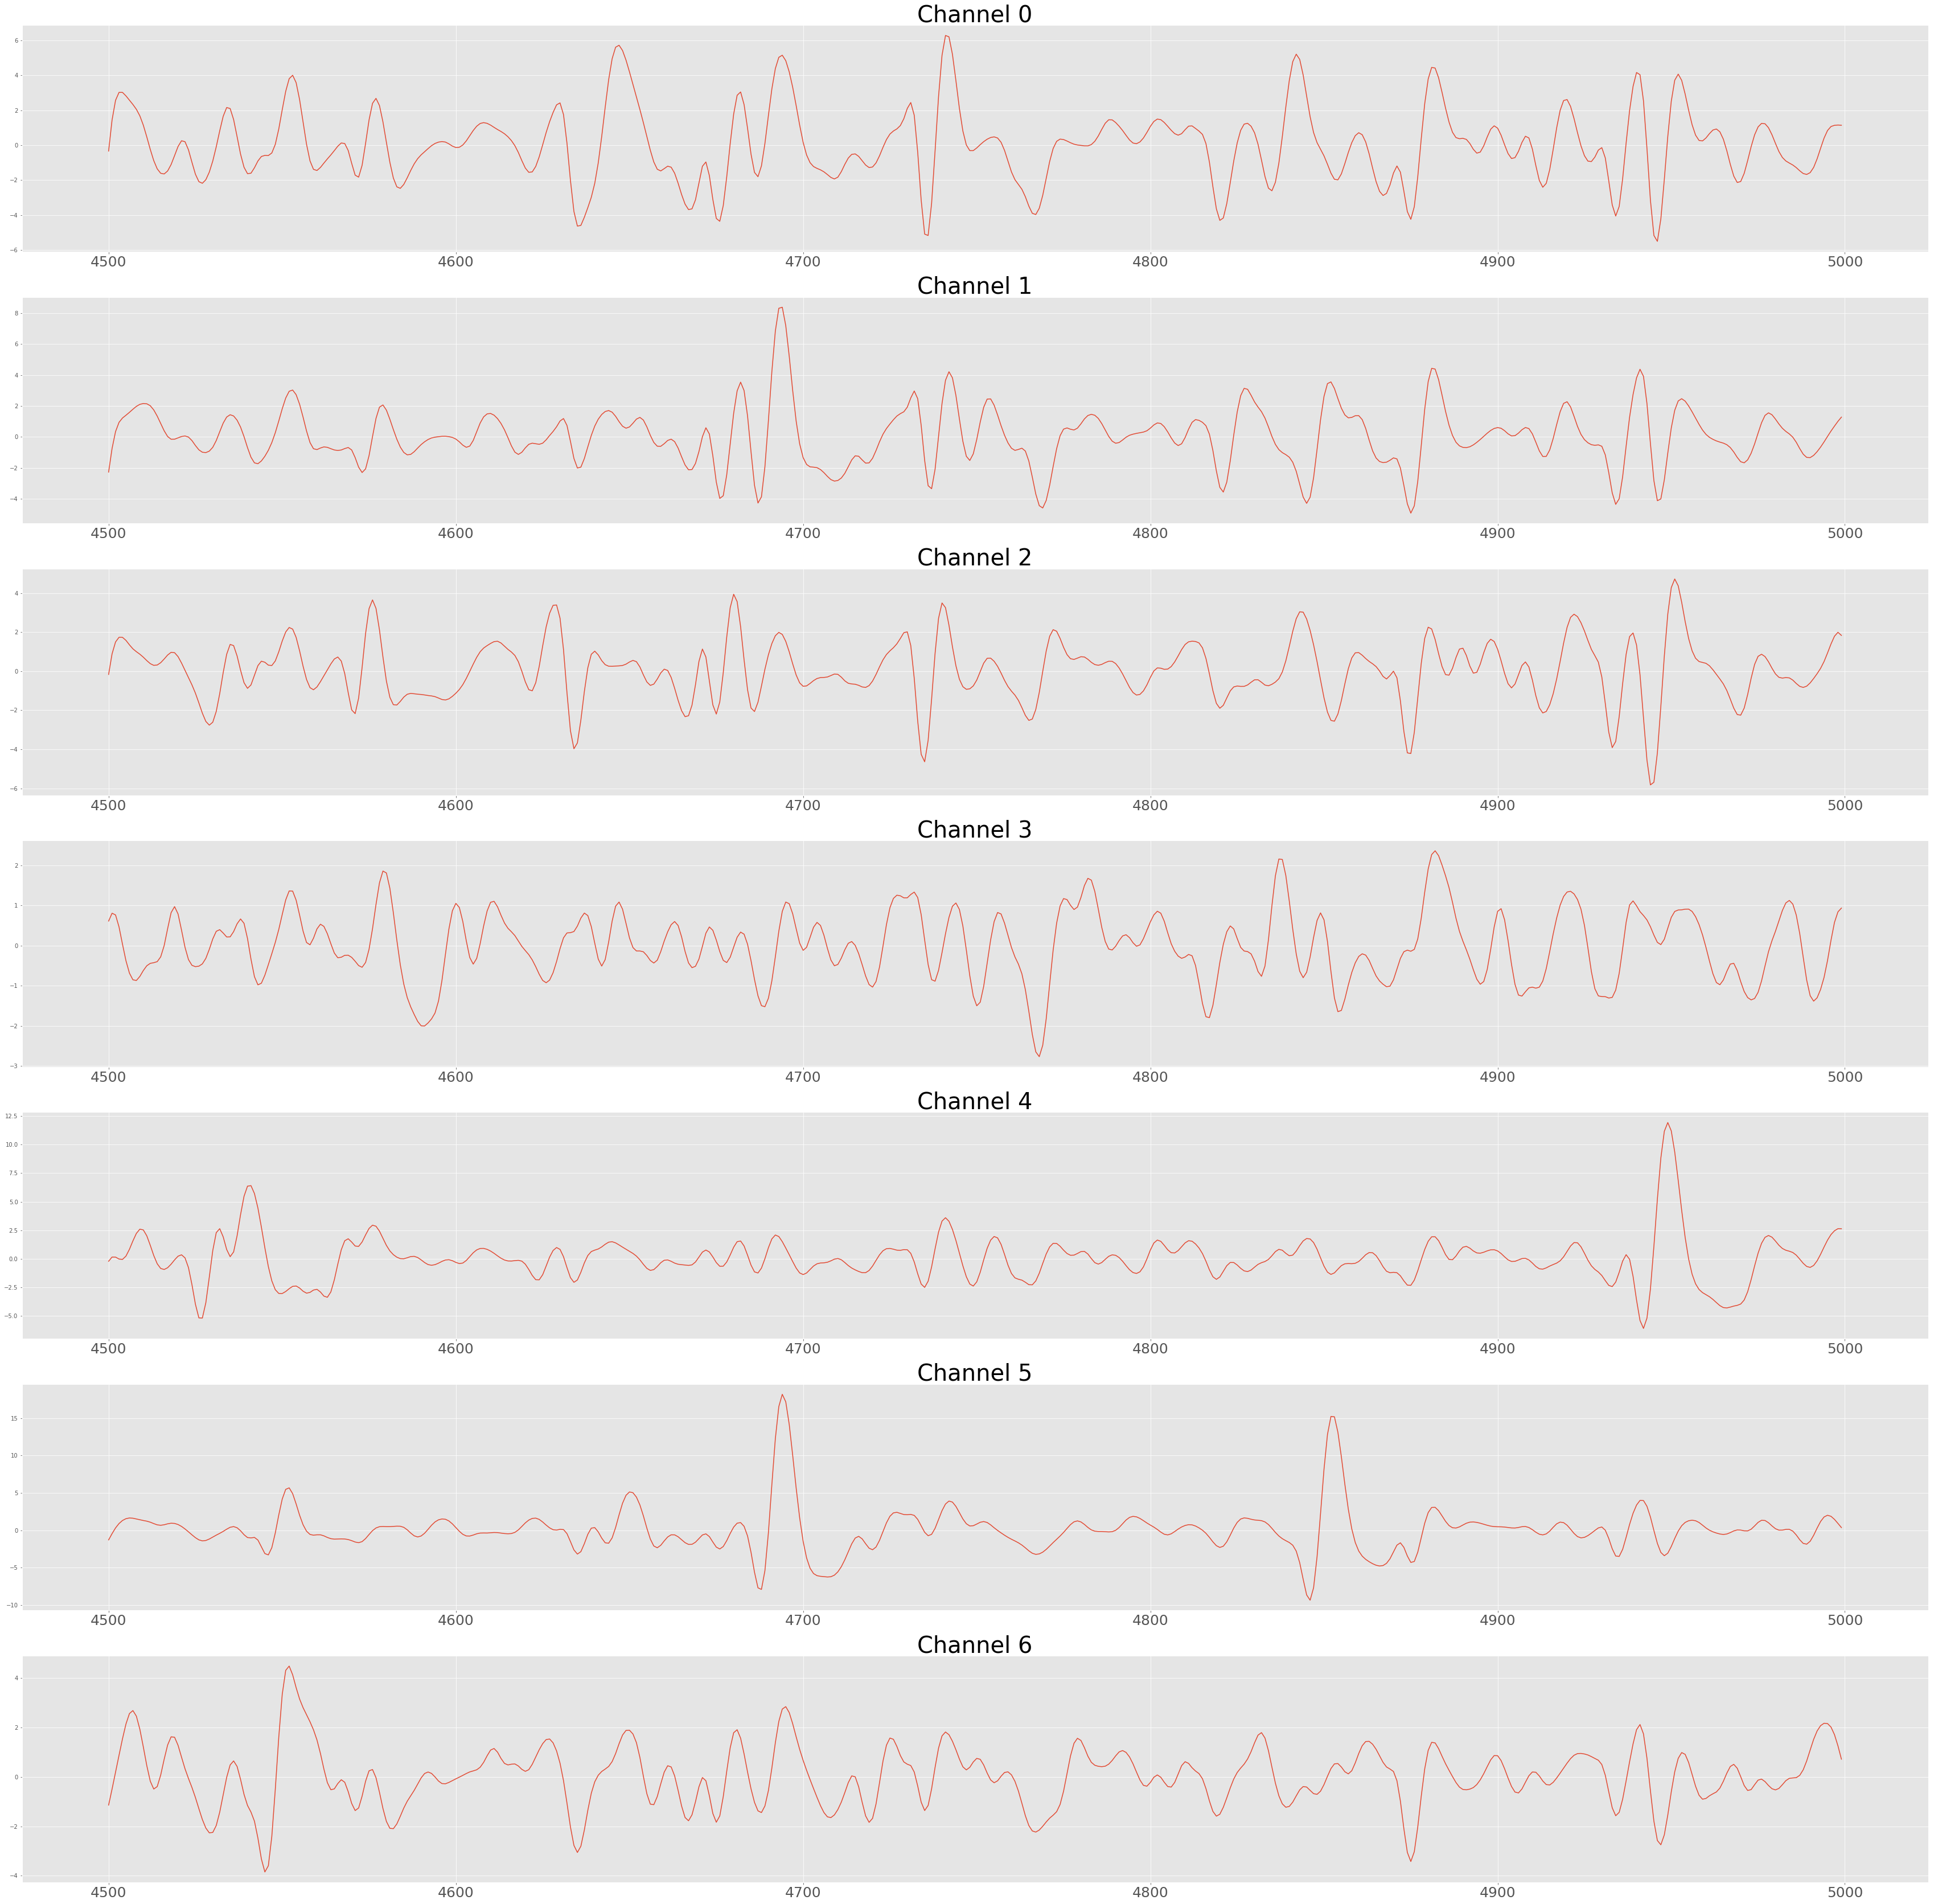

In [18]:
explorer_rec.plot_series(from_time=4500, to_time=5000)

# Geometry

Electoreds spatial location plot.

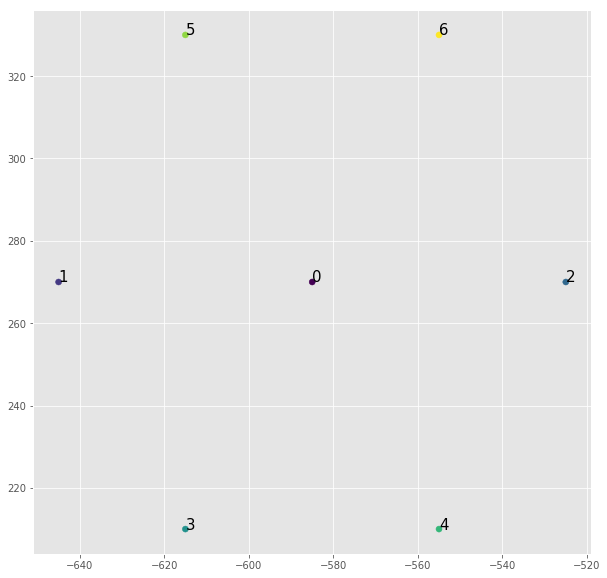

In [12]:
plt.rcParams['figure.figsize'] = (10, 10)
explorer_rec.plot_geometry()

# Training data

## Load clear spike times in channel 0

To quickly iterate over models, we are only training using spikes from channel 0.

In [19]:
clear_indexes = clear_index[0]
clear_spikes = spike_times[0][clear_indexes, 0]

In [20]:
all_spike_times = np.vstack(spike_times)[:, 0]
print('Detected {} clear spikes'.format(clear_spikes.shape[0]))

Detected 1876 clear spikes


In [15]:
# there is a bug in yass 0.1.1 that is shifting spike times
clear_spikes = clear_spikes - cfg_yass.BUFF

In [16]:
clear_spikes

array([   4184,    4747,    5594, ..., 5978986, 5984129, 5987587], dtype=int32)

# Visualizing a spike

Plot for a single detected spike.

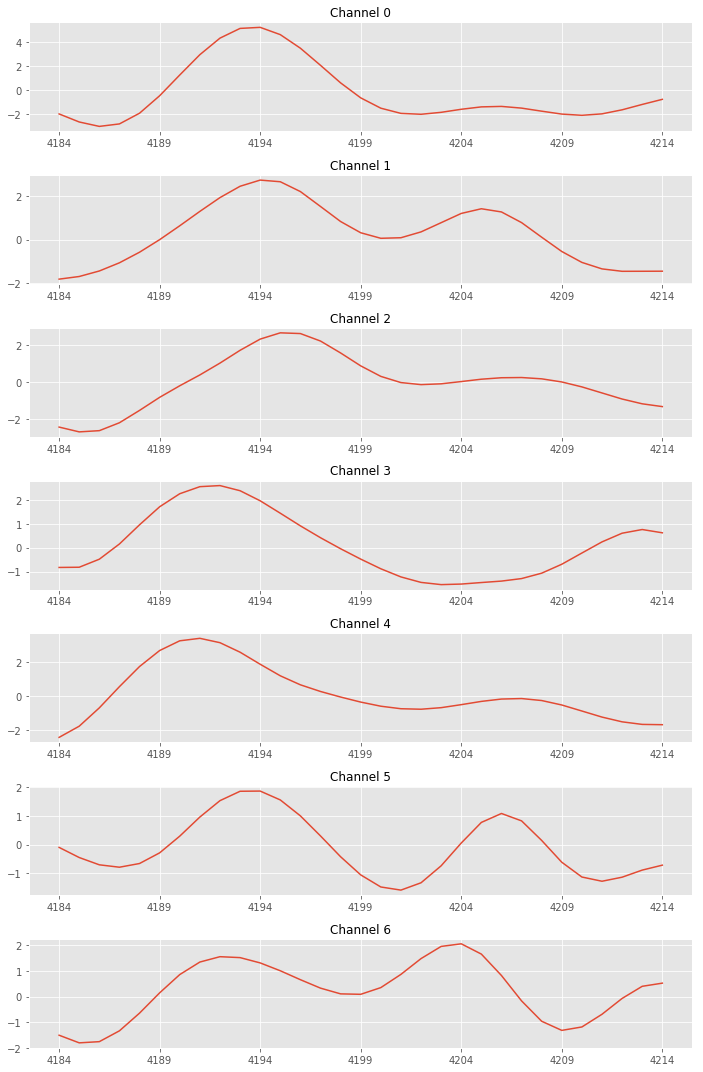

In [17]:
plt.rcParams['figure.figsize'] = (10, 15)
t = clear_spikes[0]
explorer_rec.plot_waveform(time=t, channels=range(7))

## Load waveforms around spike times

Once we hace spike times, we need to load a time window around it, we load 15 observations before and after,
so we have 31 temporal observations per spike.

In [20]:
waveforms = explorer_rec.read_waveforms(times=clear_spikes)
print('Training set dimensions: {}'.format(waveforms.shape))

Training set dimensions: (1876, 31, 7)


## Reduce waveforms temporal dimensionality from 31 to 3 and flatten data

We reduce temporal dimensionality (from 31 to 3) in each channel using an autoencoder, so we get 3 * n_channels = 21 features for the training data.

In [21]:
waveforms_reduced = explorer_train._reduce_dimension(waveforms, flatten=True)
print('Training set dimensions: {}'.format(waveforms_reduced.shape))

Training set dimensions: (1876, 21)


# Save training data and clear spike times

We save the training data and clear spike times (we will later use the spike times for visualization)

In [22]:
output_path = os.path.join(cfg['root'], 'training.npy')
np.save(output_path, waveforms_reduced)
print(f'Saved training data in {output_path}')

Saved training data in /Users/Edu/data/neural-clustering/training.npy


In [23]:
output_path = os.path.join(cfg['root'], 'clear_spikes.npy')
np.save(output_path, clear_spikes)
print(f'Saved clear spike times in {output_path}')

Saved clear spike times in /Users/Edu/data/neural-clustering/clear_spikes.npy


# Model fitting and experiment listing

This notebook shows how we can train models and list previously trained ones (along with useful information about them).

**Important:** this is just a demo to show how models are trained, due to the way Edward manages Tensorflow sessions,
each model should be trained in a different Python session, otherwise restoring it (notebooks 4-1 and 4-2 will throw errors.

In [2]:
import os

import numpy as np

from neural_clustering.model import dpmm, gmm, util
from neural_clustering.criticize import summarize_experiments
from neural_clustering import config

/Users/Edu/miniconda3/envs/test-project/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
import logging
logging.basicConfig(level=logging.INFO)

In [4]:
cfg = config.load('../config.yaml')

## Model training

### Load training data (generated in notebook 2)

In [5]:
x_train = np.load(os.path.join(cfg['root'], 'training.npy'))
print(f'x_train shape: {x_train.shape}')

x_train shape: (1876, 21)


### ...or generate toy dataset

In [6]:
# x_train = util.build_toy_dataset(500)
# print(f'x_train shape: {x_train.shape}')

## (truncated) Dirichlet Process Mixture Model

$$p(x_n | \pi, \mu, \sigma) = \sum_{k=1}^{K} \pi_k \mathrm{Normal}(x_n |\; \mu_k, \sigma_k)$$

$$ \beta_k \sim \mathrm{Beta}(1,\alpha) $$

$$ \pi_i = \beta_i \prod_{j=1}^{i-1}(1-\beta_j) $$

$$\mu_k \sim \mathrm{Normal} (\mu_k |\; \mathbf{0}, \mathbf{I}) $$

$$\sigma_k^2 \sim \mathrm{Gamma}(\sigma^2_k |\; a, b) $$

There is a bug in Edward that *sometimes* throws an error when fitting, it
occurs more often with truncation levels > 5. It has been reported in [discourse](https://discourse.edwardlib.org/t/variational-inference-for-dirichlet-process-mixtures/251/2) already

In [14]:
# small number of iterations for testing
dpmm.fit(x_train, truncation_level=3, cfg=cfg,
         inference_params=dict(n_iter=500))

500/500 [100%] ██████████████████████████████ Elapsed: 6s | Loss: 512528.469


INFO:neural_clustering.model.dpmm:Session saved in /Users/Edu/data/neural-clustering/sessions/30-Nov-2017@15-18-08-DPMM/session.ckpt
INFO:neural_clustering.model.dpmm:Training data saved in /Users/Edu/data/neural-clustering/sessions/30-Nov-2017@15-18-08-DPMM/training.npy
INFO:neural_clustering.model.dpmm:Params saved in /Users/Edu/data/neural-clustering/sessions/30-Nov-2017@15-18-08-DPMM/params.yaml


## Gaussian Mixture Model

$$p(x_n | \pi, \mu, \sigma) = \sum_{k=1}^{K} \pi_k \mathrm{Normal}(x_n |\; \mu_k, \sigma_k)$$

$$\pi \sim \mathrm{Dirichlet}(\pi, \alpha \mathbf{1}_K) $$

$$\mu_k \sim \mathrm{Normal} (\mu_k |\; \mathbf{0}, \mathbf{I}) $$

$$\sigma_k^2 \sim \mathrm{Gamma}(\sigma^2_k |\; a, b) $$

In [8]:
# small number of iterations for testing
gmm.fit(x_train, k=13, cfg=cfg, samples=10)

INFO:neural_clustering.model.gmm:Session saved in /Users/Edu/data/neural-clustering/sessions/30-Nov-2017@16-42-15-GMM/session.ckpt
INFO:neural_clustering.model.gmm:Training data saved in /Users/Edu/data/neural-clustering/sessions/30-Nov-2017@16-42-15-GMM/training.npy
INFO:neural_clustering.model.gmm:Params saved in /Users/Edu/data/neural-clustering/sessions/30-Nov-2017@16-42-15-GMM/params.yaml


## List experiments

List all previously trained models along with some useful information.

In [5]:
summarize_experiments(cfg)

# GMM Model criticism

Checking for convergence (GMM is trained using Gibbs), cluster sizes and Edward's PPC plots.

**Important**: restart the kernel when changing the experiment to evaluate

## Experiment to evaluate

In [1]:
EXPERIMENT_NAME = '30-Nov-2017@16-53-17-GMM'

In [2]:
%matplotlib inline

import logging
import os

import numpy as np
import edward as ed
import tensorflow as tf
import matplotlib.pyplot as plt

from neural_clustering.criticize import (plot, restore,
                                         store_cluster_assignments,
                                         ppc_plot,
                                         summarize_experiment)
from neural_clustering import config

/Users/Edu/miniconda3/envs/test-project/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 20)

logging.basicConfig(level=logging.INFO)

In [4]:
cfg = config.load('../../config.yaml')

In [5]:
exp = restore.experiment(cfg, EXPERIMENT_NAME)

In [6]:
x_pred = exp['x_pred']
x_train = exp['x_train'].astype('float32')

## Experiment summary

In [7]:
summarize_experiment(cfg, EXPERIMENT_NAME)

## qpi (mixture proportions) over iterations

Proportion parameters over every iteration.

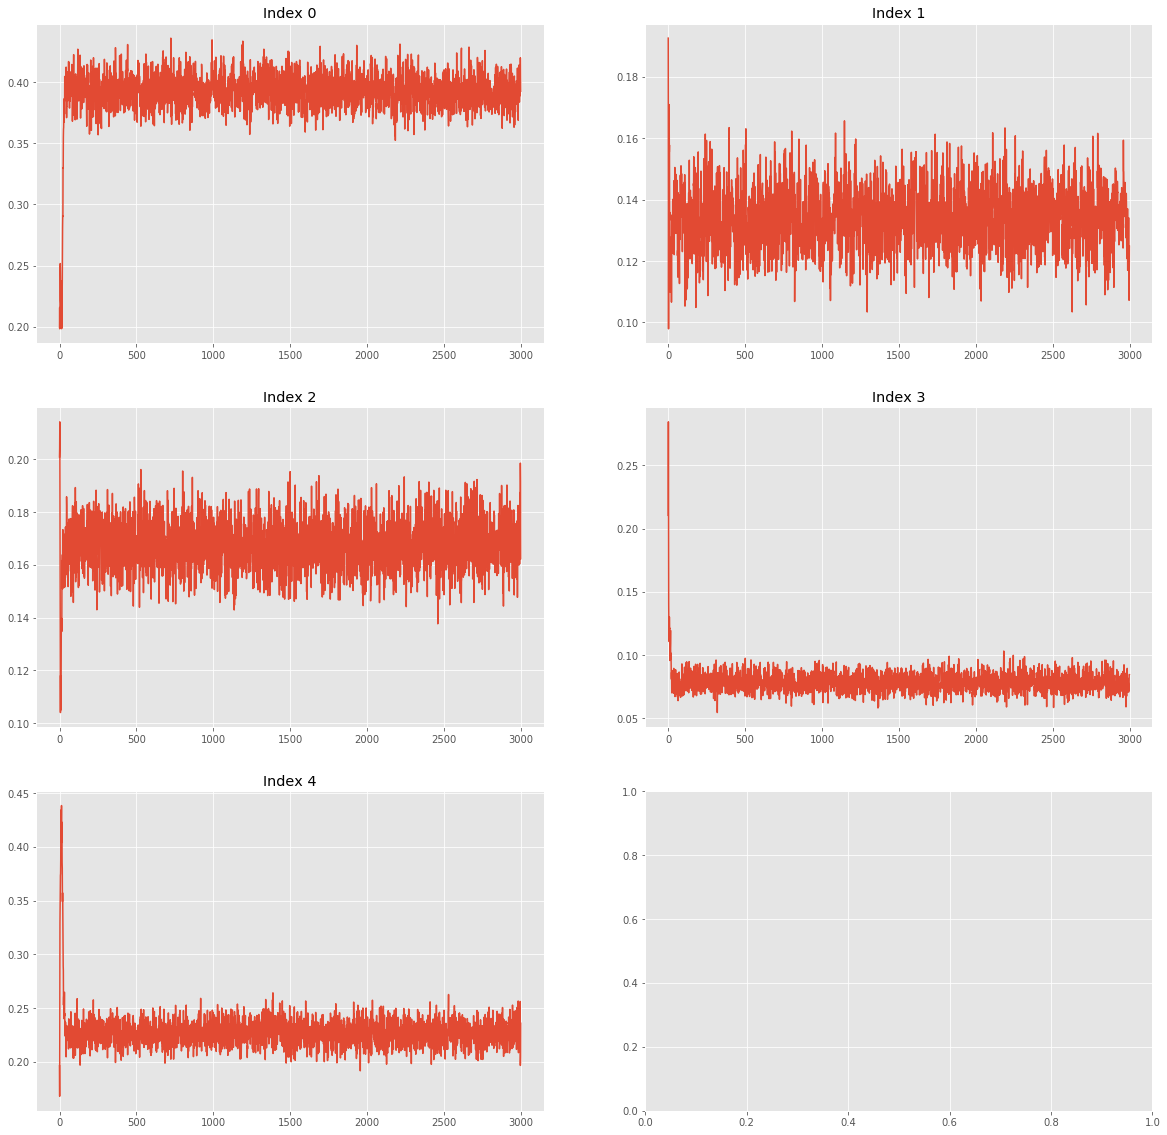

In [8]:
plot.params_over_iterations(exp['qpi'], axis=1, sharex=False)

## qmu (mixture centers) over iterations

Mixture means over every iteration.

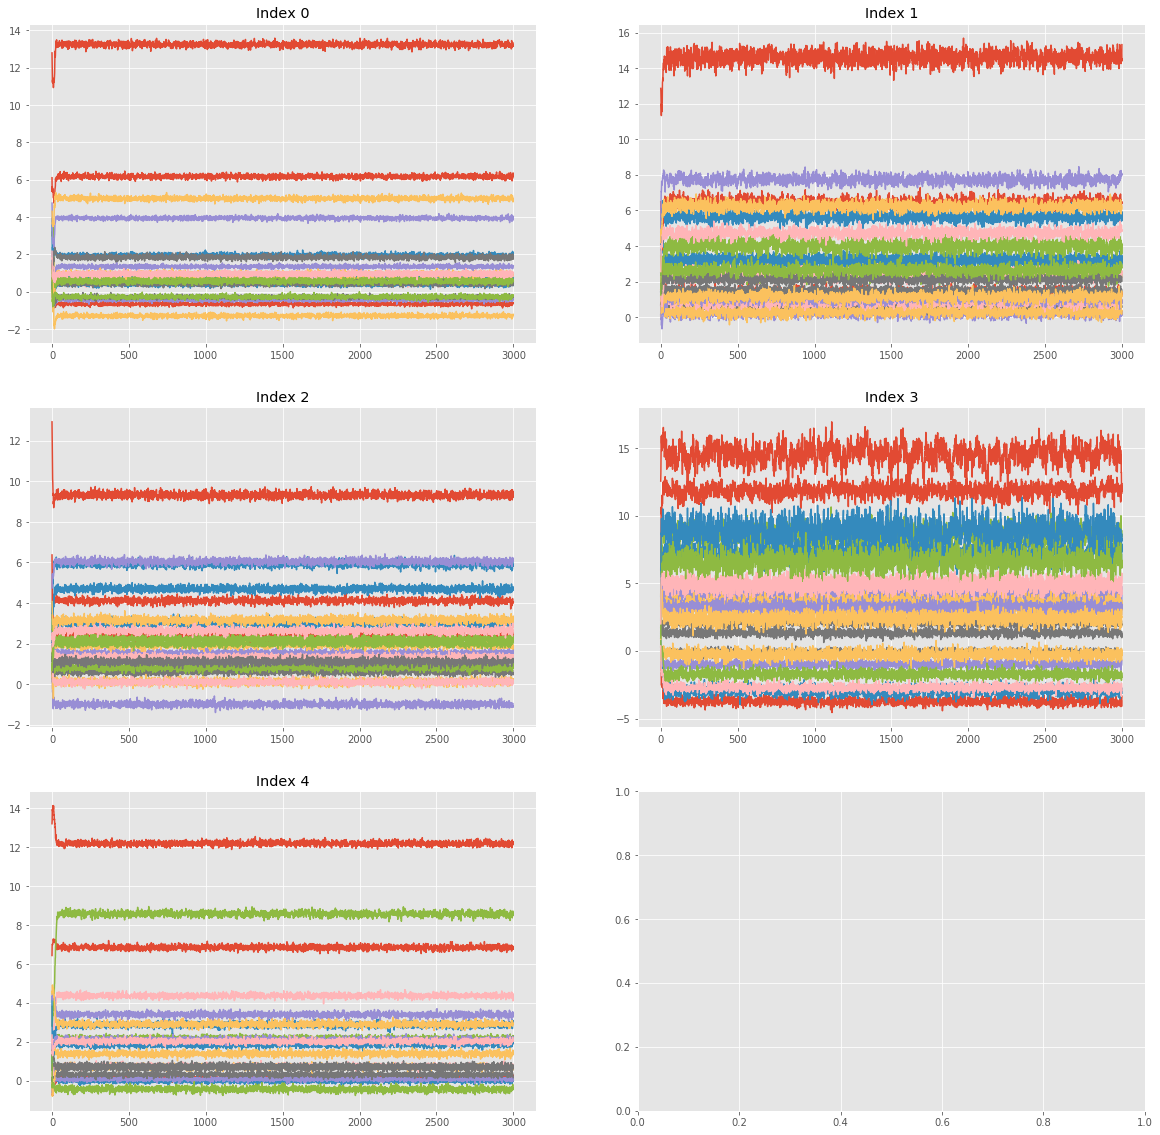

In [9]:
plot.params_over_iterations(exp['qmu'], axis=1, sharex=False)

## Get cluster ssignments

Find cluster assignments and save them, they will later be used in notebook 5.

In [10]:
clusters = store_cluster_assignments(cfg, exp['x_train'], exp['qmu'], exp['params'])

INFO:neural_clustering.criticize.criticize:Cluster assignmens stored in /Users/Edu/data/neural-clustering/sessions/30-Nov-2017@16-53-17-GMM/clusters.npy


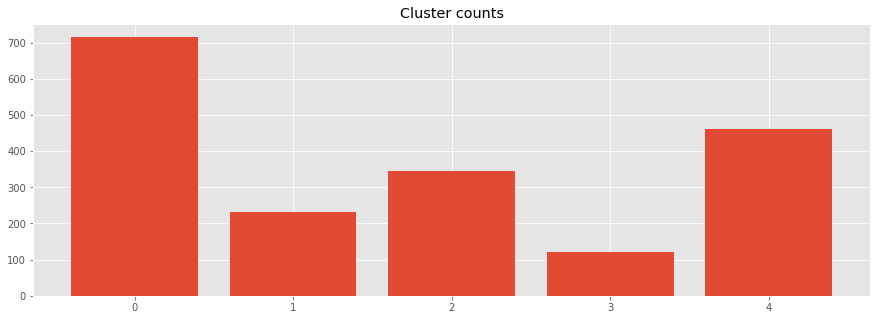

In [11]:
plt.rcParams['figure.figsize'] = (15, 5)
plot.cluster_counts(clusters)

## Log likelihood and mean squared error

Evaluate log likelihood and mean squared error.

In [12]:
log_lik = ed.evaluate('log_likelihood', data={x_pred: x_train})
mse = ed.evaluate('mean_squared_error', data={x_pred: x_train})
print(f'Log likelihood is: {log_lik:0.2f}')
print(f'Mean squared error is: {mse:0.2f}')

Log likelihood is: -23913.64
Mean squared error is: 8.86


## Posterior predictive checks

PPC plots for mean, max and min.

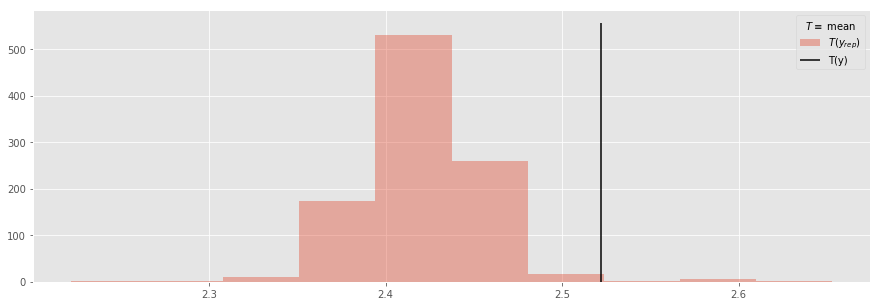

In [13]:
ppc_plot(lambda xs, mus: tf.reduce_mean(xs[x_pred]), 'mean', x_pred, x_train)

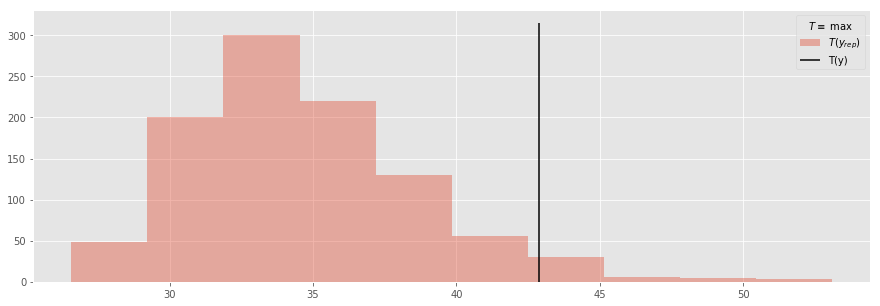

In [14]:
ppc_plot(lambda xs, mus: tf.reduce_max(xs[x_pred]), 'max', x_pred, x_train)

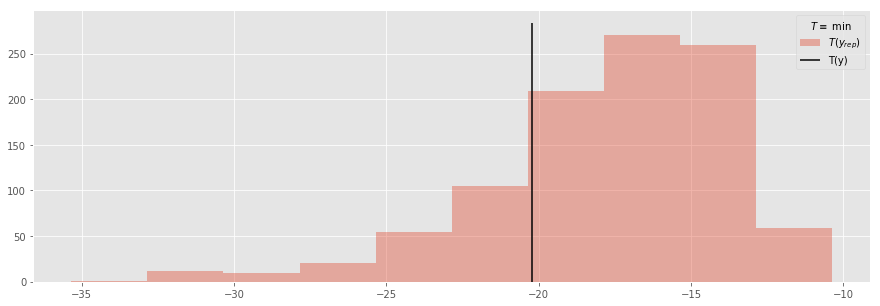

In [15]:
ppc_plot(lambda xs, mus: tf.reduce_min(xs[x_pred]), 'min', x_pred, x_train)

# Clustering evaluation

In this notebook, we visually inspect the clustering assignments.

## Experiment to evaluate

In [1]:
EXPERIMENT_NAME = '30-Nov-2017@16-53-17-GMM'

In [2]:
%matplotlib inline

import logging
import os

import numpy as np

from yass.neuralnet import NeuralNetDetector
from yass.config import Config

from neural_clustering.criticize import summarize_experiment
from neural_clustering.explore import (SpikeTrainExplorer,
                                       RecordingExplorer)
from neural_clustering import config


import matplotlib.pyplot as plt

/Users/Edu/miniconda3/envs/test-project/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 15)

In [4]:
logging.basicConfig(level=logging.ERROR)

## Loading configuration files and YASS output

In [5]:
# load configuration files
cfg_yass = Config.from_yaml('../../yass_config/demo.yaml')
cfg = config.load('../../config.yaml')

In [6]:
# load data generated from yass
files = ['score', 'clear_index', 'spike_times', 'spike_train', 'spike_left', 'templates']

(score, clear_index,
 spike_times, spike_train,
 spike_left, templates) = [np.load(os.path.join(cfg['root'], 'yass/{}.npy'.format(f))) for f in  files]

## Experiment summary

In [7]:
summarize_experiment(cfg, EXPERIMENT_NAME)

## Loading raw recordings, geometry file and projection matrix

In [8]:
# load standarized recordings (these are raw recordings + filter + standarization)
path_to_recordings = os.path.join(cfg_yass.root, 'tmp/standarized.bin')
# load gemetry file (position for every electro)
path_to_geometry = os.path.join(cfg_yass.root, cfg_yass.geomFile)

In [9]:
# load projection matrix (to reduce dimensionality)
proj = NeuralNetDetector(cfg_yass).load_w_ae()

## Load clustering results and clear spike times

We load the clustering assignments from the experiment

In [10]:
clusters = np.load(os.path.join(cfg['root'], 'sessions', EXPERIMENT_NAME, 'clusters.npy'))
clear_spikes = np.load(os.path.join(cfg['root'], 'clear_spikes.npy'))
results = np.vstack([clear_spikes, clusters]).T
group_ids = np.unique(clusters)

## Initializing explorers

These helper classes contain several functions for plotting results.

In [11]:
# initialize explorers, these objects implement functions for plotting
# the output from YASS
explorer_rec = RecordingExplorer(path_to_recordings,
                                 path_to_geometry,
                                 dtype='float64',
                                 window_size=cfg_yass.spikeSize,
                                 n_channels=cfg_yass.nChan,
                                 neighbor_radius=cfg_yass.spatialRadius)

explorer_train = SpikeTrainExplorer(templates,
                                    results,
                                    explorer_rec,
                                    proj)

## Templates

Build templates from clusters: take every point in each cluster, get the original waveform (31 temporal observations x 7 channels) and average all elements. Then plot the templates.

In [12]:
def make_template(group_id):
    wfs = explorer_train.waveforms_for_group(group_id=group_id, channels=range(7))
    return np.average(wfs, axis=0)

In [13]:
templates_new = np.stack([make_template(group_id) for group_id in group_ids]).transpose(2, 1, 0)

In [14]:
explorer_train = SpikeTrainExplorer(templates_new,
                                    results,
                                    explorer_rec,
                                    proj)

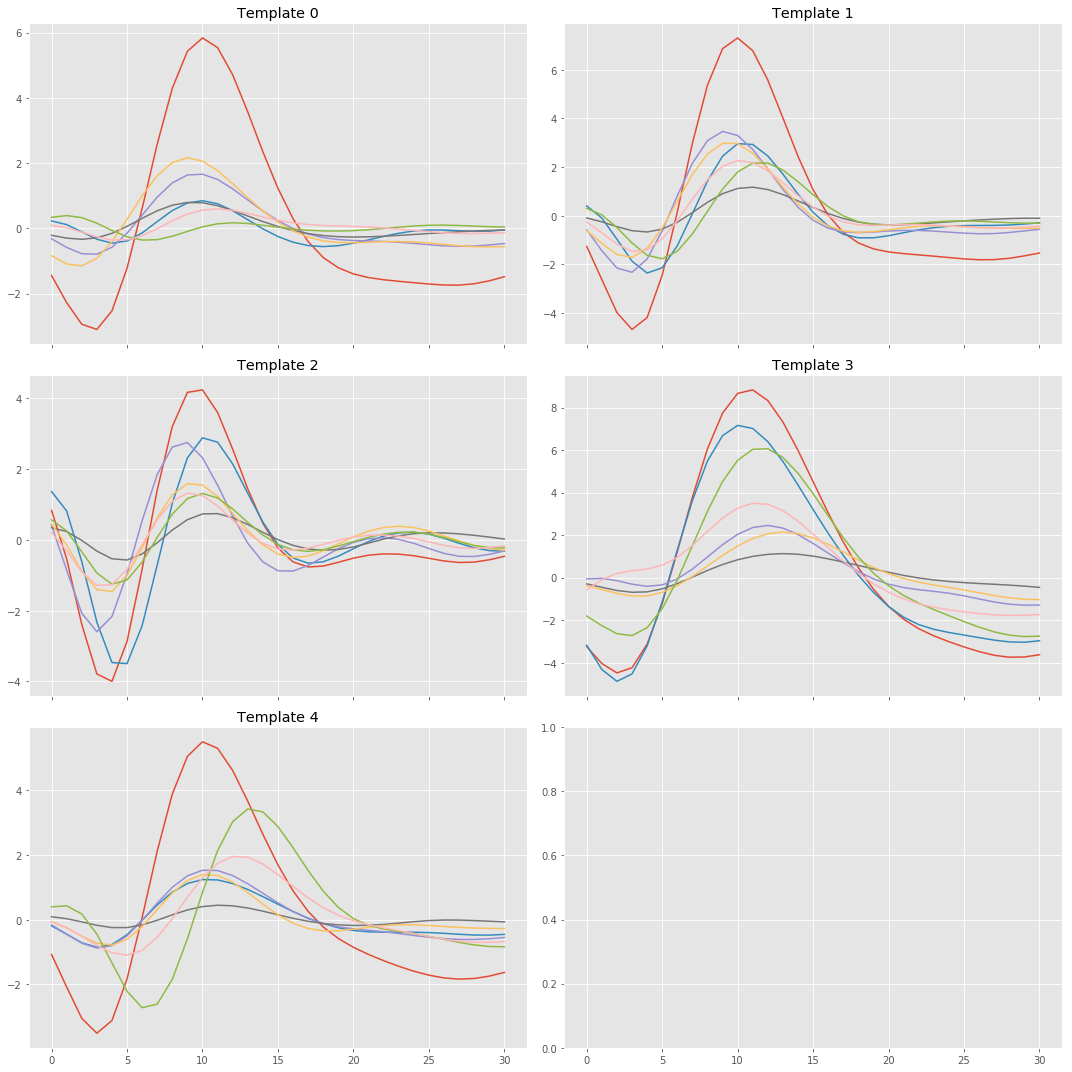

In [15]:
plt.rcParams['figure.figsize'] = (15, 15)
explorer_train.plot_templates(group_ids=group_ids)

## Cluster plots

Plot nehgboring clusters: get all the templates, compute the similarity among them (by comparing the squared difference in each temporal observation in each channel)

Then for every template, get the two most similar templates, find the cluster id for each and get the cluster elements for that cluster id.

Project all the points in the three clusters using LDA and plot.

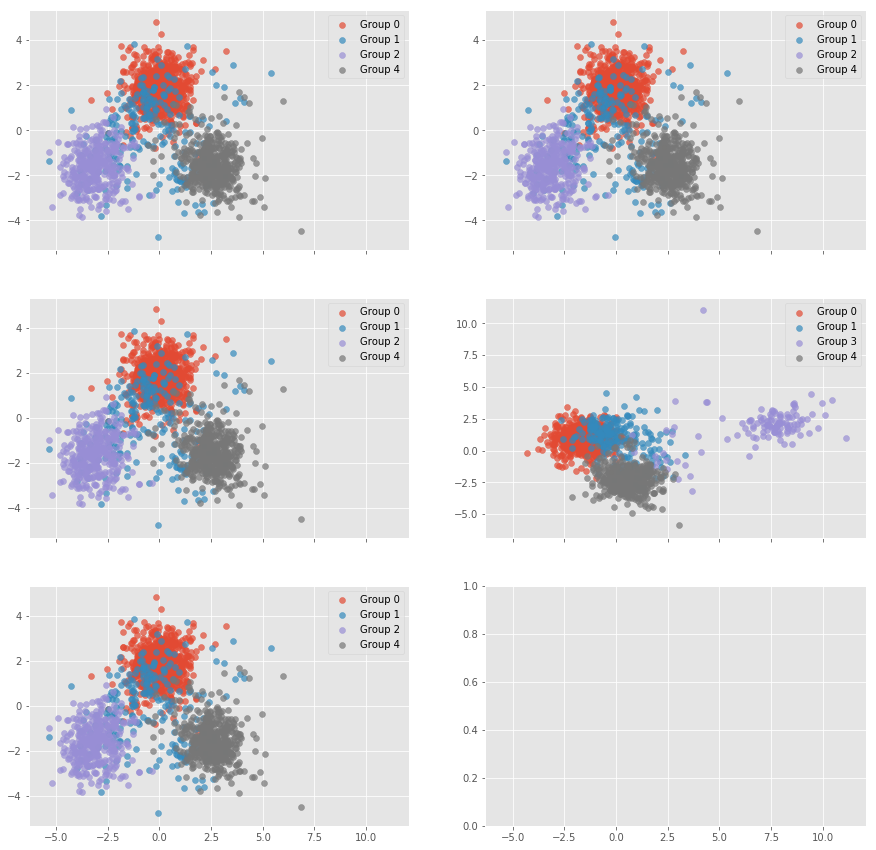

In [16]:
plt.rcParams['figure.figsize'] = (15, 15)
explorer_train.plot_all_clusters(k=3)

## Plotting specific groups

Plot 3 similar clusters along with the template for each group.

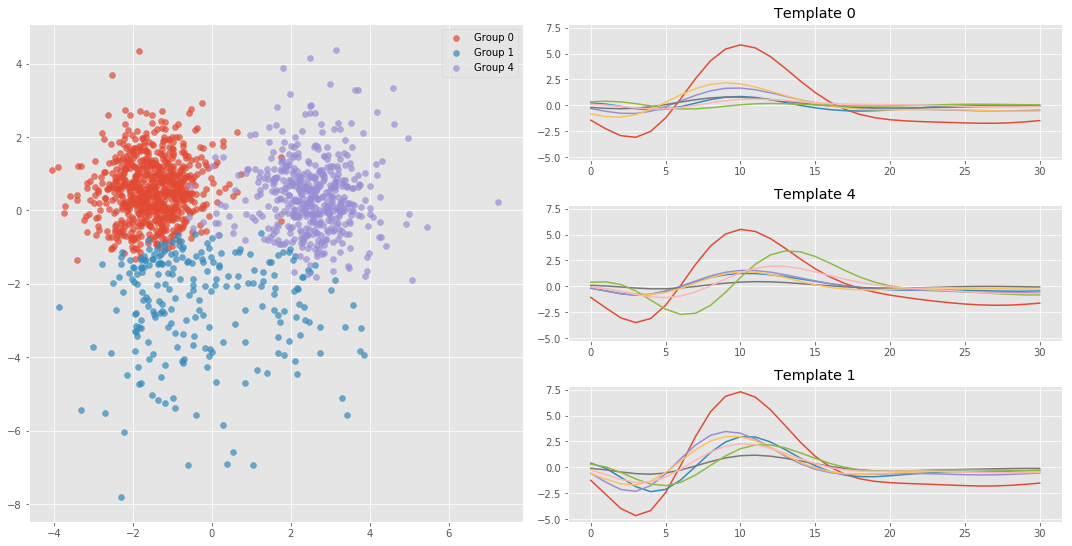

In [17]:
explorer_train.plot_waveforms_and_clusters(group_id=0)

# GMM Model criticism

Checking for convergence (GMM is trained using Gibbs), cluster sizes and Edward's PPC plots.

**Important**: restart the kernel when changing the experiment to evaluate

## Experiment to evaluate

In [1]:
EXPERIMENT_NAME = '30-Nov-2017@16-58-38-GMM'

In [2]:
%matplotlib inline

import logging
import os

import numpy as np
import edward as ed
import tensorflow as tf
import matplotlib.pyplot as plt

from neural_clustering.criticize import (plot, restore,
                                         store_cluster_assignments,
                                         ppc_plot,
                                         summarize_experiment)
from neural_clustering import config

/Users/Edu/miniconda3/envs/test-project/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 20)

logging.basicConfig(level=logging.INFO)

In [4]:
cfg = config.load('../../config.yaml')

In [5]:
exp = restore.experiment(cfg, EXPERIMENT_NAME)

In [6]:
x_pred = exp['x_pred']
x_train = exp['x_train'].astype('float32')

## Experiment summary

In [7]:
summarize_experiment(cfg, EXPERIMENT_NAME)

## qpi (mixture proportions) over iterations

Proportion parameters over every iteration.

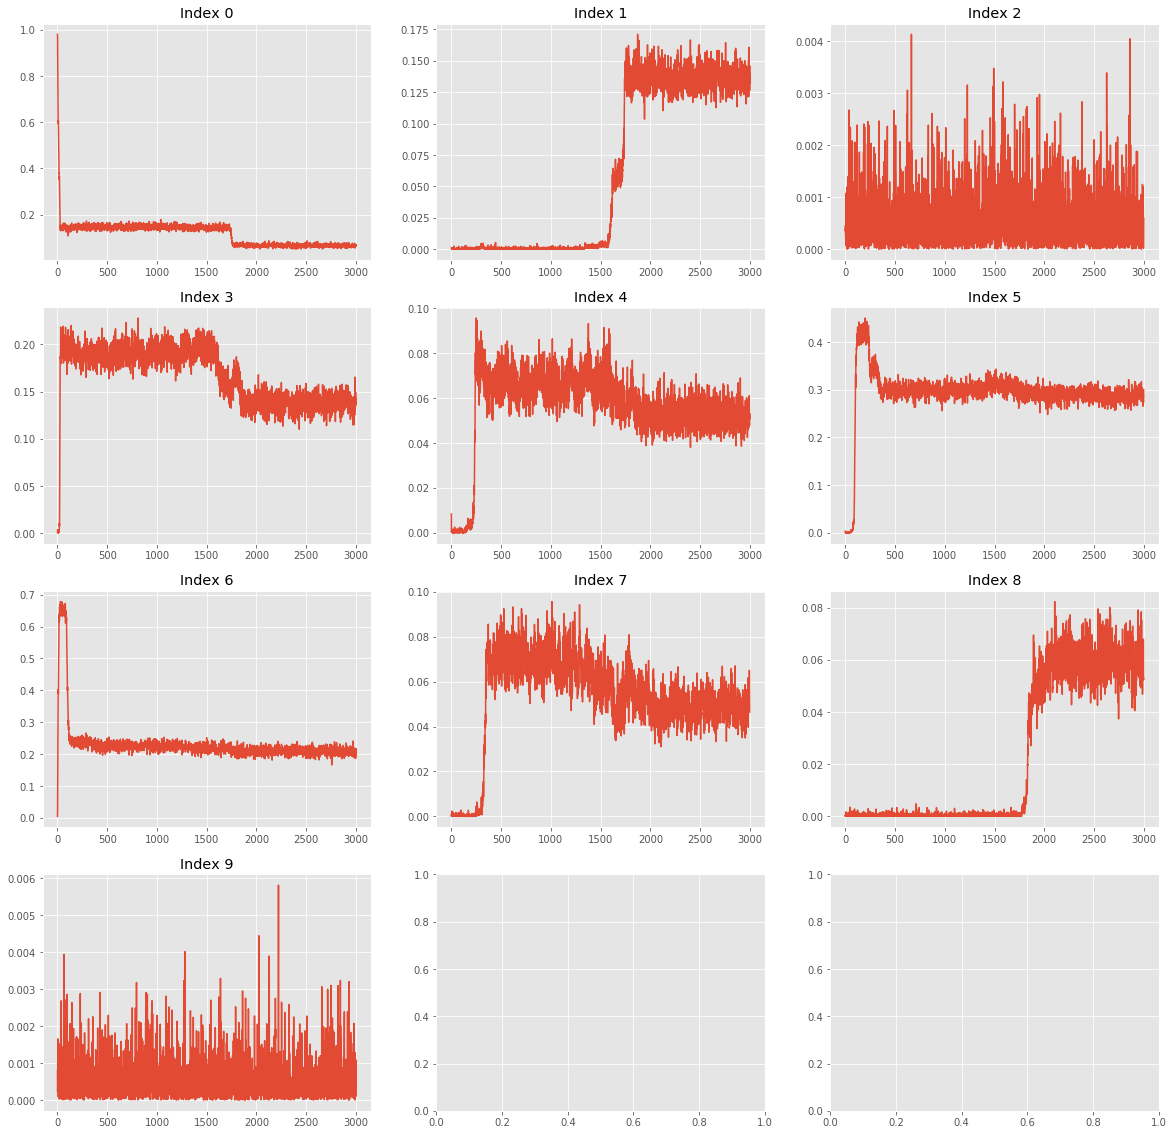

In [8]:
plot.params_over_iterations(exp['qpi'], axis=1, sharex=False)

## qmu (mixture centers) over iterations

Mixture means over every iteration.

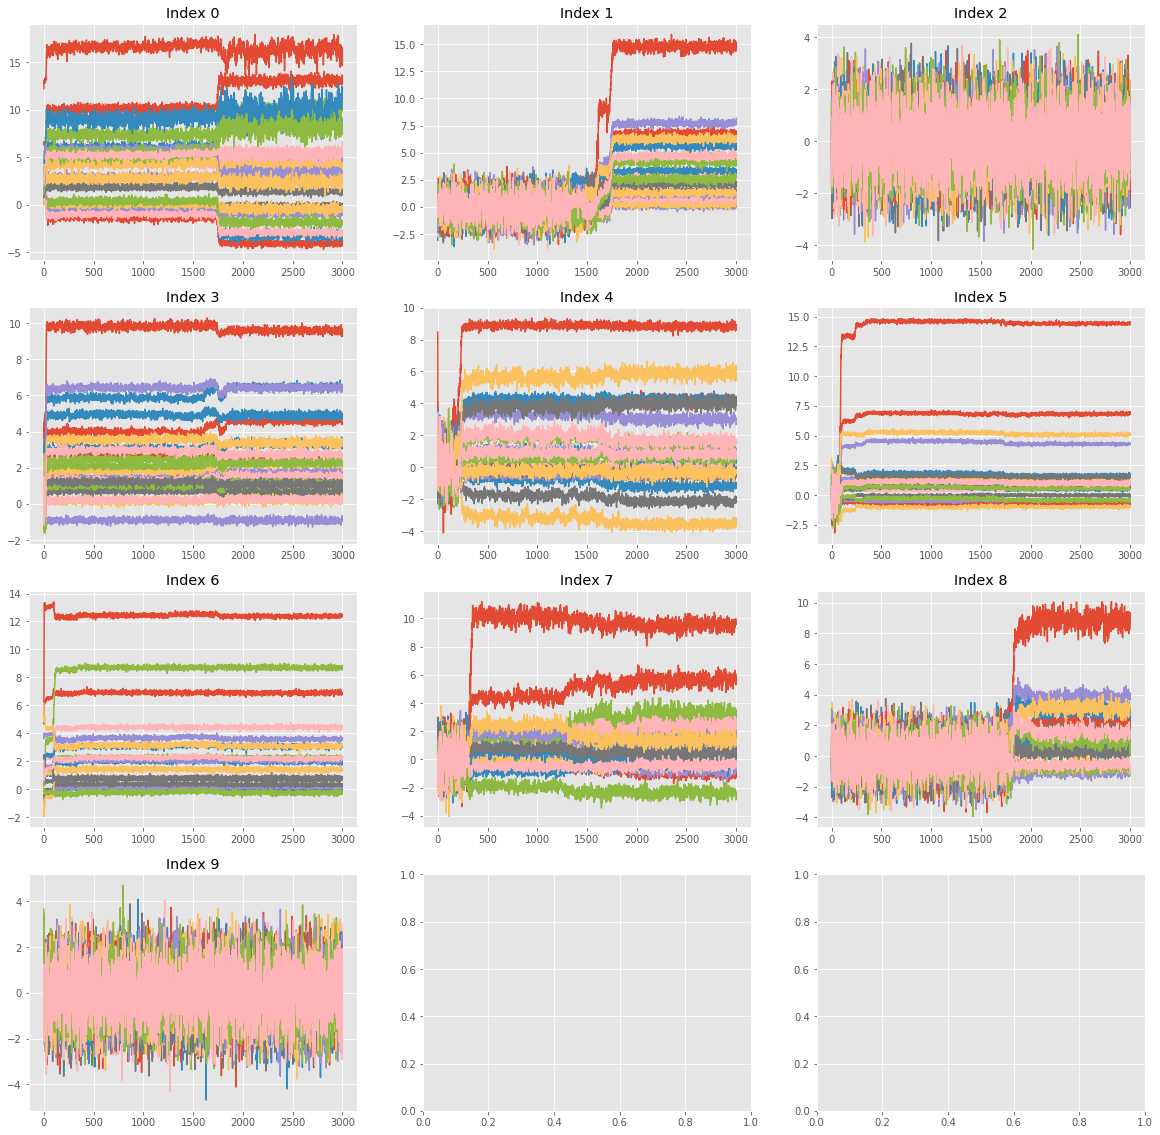

In [9]:
plot.params_over_iterations(exp['qmu'], axis=1, sharex=False)

## Get cluster ssignments

Find cluster assignments and save them, they will later be used in notebook 5.

In [10]:
clusters = store_cluster_assignments(cfg, exp['x_train'], exp['qmu'], exp['params'])

INFO:neural_clustering.criticize.criticize:Cluster assignmens stored in /Users/Edu/data/neural-clustering/sessions/30-Nov-2017@16-58-38-GMM/clusters.npy


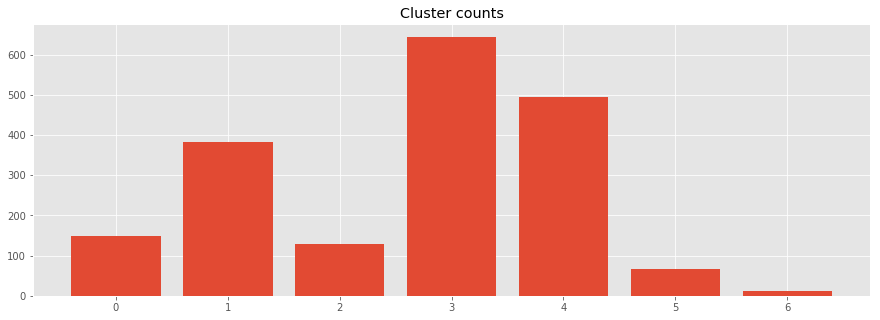

In [11]:
plt.rcParams['figure.figsize'] = (15, 5)
plot.cluster_counts(clusters)

## Log likelihood and mean squared error

Evaluate log likelihood and mean squared error.

In [12]:
log_lik = ed.evaluate('log_likelihood', data={x_pred: x_train})
mse = ed.evaluate('mean_squared_error', data={x_pred: x_train})
print(f'Log likelihood is: {log_lik:0.2f}')
print(f'Mean squared error is: {mse:0.2f}')

Log likelihood is: -14229.45
Mean squared error is: 8.97


## Posterior predictive checks

PPC plots for mean, max and min.

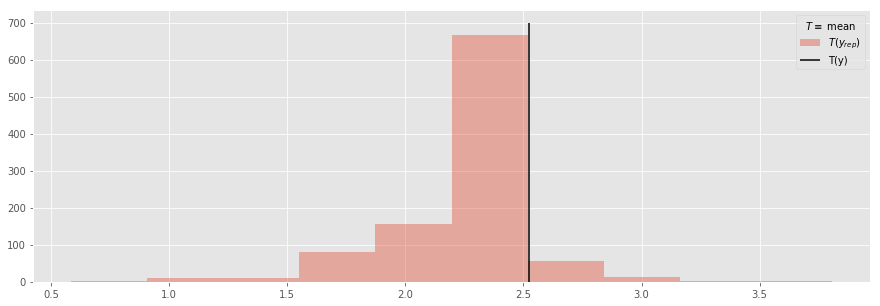

In [13]:
ppc_plot(lambda xs, mus: tf.reduce_mean(xs[x_pred]), 'mean', x_pred, x_train)

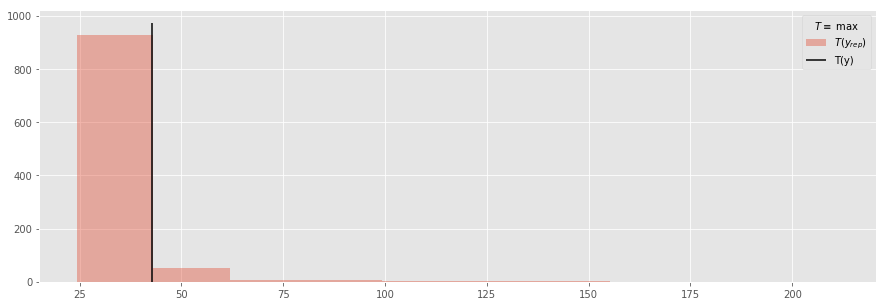

In [14]:
ppc_plot(lambda xs, mus: tf.reduce_max(xs[x_pred]), 'max', x_pred, x_train)

In [15]:
ppc_plot(lambda xs, mus: tf.reduce_min(xs[x_pred]), 'min', x_pred, x_train)

# Clustering evaluation

In this notebook, we visually inspect the clustering assignments.

## Experiment to evaluate

In [1]:
EXPERIMENT_NAME = '30-Nov-2017@16-58-38-GMM'

In [2]:
%matplotlib inline

import logging
import os

import numpy as np

from yass.neuralnet import NeuralNetDetector
from yass.config import Config

from neural_clustering.criticize import summarize_experiment
from neural_clustering.explore import (SpikeTrainExplorer,
                                       RecordingExplorer)
from neural_clustering import config


import matplotlib.pyplot as plt

/Users/Edu/miniconda3/envs/test-project/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 15)

In [4]:
logging.basicConfig(level=logging.ERROR)

## Loading configuration files and YASS output

In [5]:
# load configuration files
cfg_yass = Config.from_yaml('../../yass_config/demo.yaml')
cfg = config.load('../../config.yaml')

In [6]:
# load data generated from yass
files = ['score', 'clear_index', 'spike_times', 'spike_train', 'spike_left', 'templates']

(score, clear_index,
 spike_times, spike_train,
 spike_left, templates) = [np.load(os.path.join(cfg['root'], 'yass/{}.npy'.format(f))) for f in  files]

## Experiment summary

In [7]:
summarize_experiment(cfg, EXPERIMENT_NAME)

## Loading raw recordings, geometry file and projection matrix

In [8]:
# load standarized recordings (these are raw recordings + filter + standarization)
path_to_recordings = os.path.join(cfg_yass.root, 'tmp/standarized.bin')
# load gemetry file (position for every electro)
path_to_geometry = os.path.join(cfg_yass.root, cfg_yass.geomFile)

In [9]:
# load projection matrix (to reduce dimensionality)
proj = NeuralNetDetector(cfg_yass).load_w_ae()

## Load clustering results and clear spike times

We load the clustering assignments from the experiment

In [10]:
clusters = np.load(os.path.join(cfg['root'], 'sessions', EXPERIMENT_NAME, 'clusters.npy'))
clear_spikes = np.load(os.path.join(cfg['root'], 'clear_spikes.npy'))
results = np.vstack([clear_spikes, clusters]).T
group_ids = np.unique(clusters)

## Initializing explorers

These helper classes contain several functions for plotting results.

In [11]:
# initialize explorers, these objects implement functions for plotting
# the output from YASS
explorer_rec = RecordingExplorer(path_to_recordings,
                                 path_to_geometry,
                                 dtype='float64',
                                 window_size=cfg_yass.spikeSize,
                                 n_channels=cfg_yass.nChan,
                                 neighbor_radius=cfg_yass.spatialRadius)

explorer_train = SpikeTrainExplorer(templates,
                                    results,
                                    explorer_rec,
                                    proj)

## Templates

Build templates from clusters: take every point in each cluster, get the original waveform (31 temporal observations x 7 channels) and average all elements. Then plot the templates.

In [12]:
def make_template(group_id):
    wfs = explorer_train.waveforms_for_group(group_id=group_id, channels=range(7))
    return np.average(wfs, axis=0)

In [13]:
templates_new = np.stack([make_template(group_id) for group_id in group_ids]).transpose(2, 1, 0)

In [14]:
explorer_train = SpikeTrainExplorer(templates_new,
                                    results,
                                    explorer_rec,
                                    proj)

In [15]:
plt.rcParams['figure.figsize'] = (15, 15)
explorer_train.plot_templates(group_ids=group_ids)

## Cluster plots

Plot nehgboring clusters: get all the templates, compute the similarity among them (by comparing the squared difference in each temporal observation in each channel)

Then for every template, get the two most similar templates, find the cluster id for each and get the cluster elements for that cluster id.

Project all the points in the three clusters using LDA and plot.

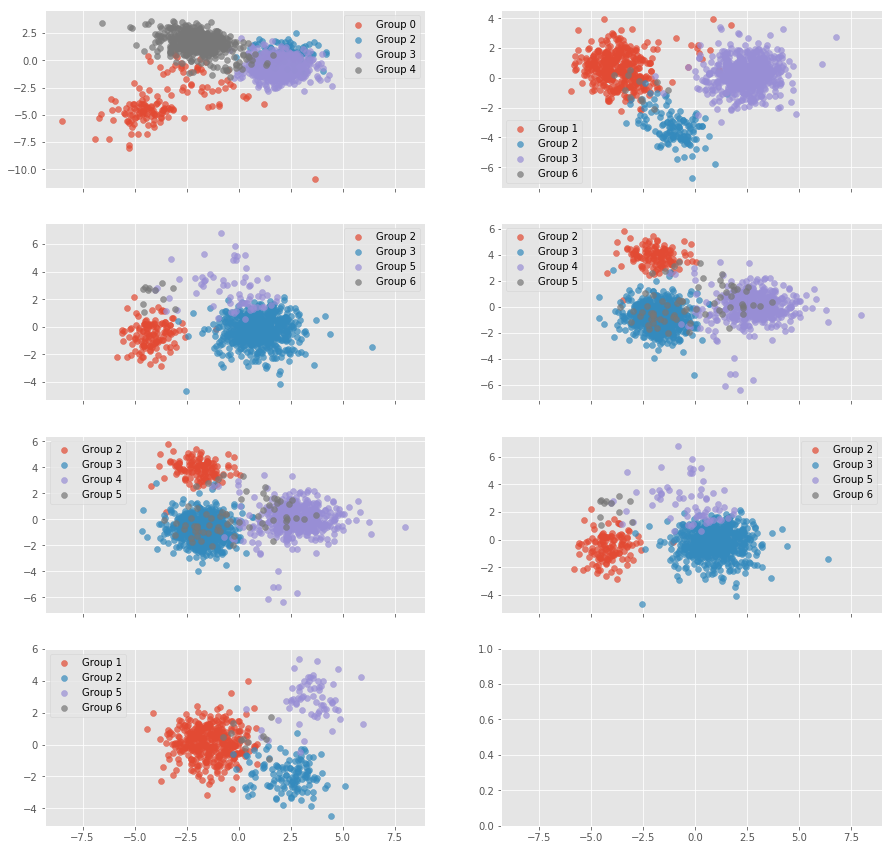

In [16]:
plt.rcParams['figure.figsize'] = (15, 15)
explorer_train.plot_all_clusters(k=3)

## Plotting specific groups

Plot 3 similar clusters along with the template for each group.

In [17]:
explorer_train.plot_waveforms_and_clusters(group_id=0)

# Conclusions

* **Probabilistic programming is great**, it helped to quickly iterate experiments: trying out new models, inference algorithms and criticize every experiment

* The research team I am working with has invested **a lot of effort** in evaluating our **current clustering algorithm (MFM)**, such algorithm is a **black-box** for everyone but the original programmer, since it was implemented from scratch (not probabilistic progamming at all)

* The output are the clustering assignments, so **we do not have a way** of using probabilistic approaches (like PPCs) **to evaluate performance** without first disentangling the black-box

* Although we are not currently using Edward in the YASS package (but I hope we start using it soon), the **results** from this project are **helping us improve YASS**. If we manage to implement the MFM algorithm in Edward, we might will merge it into YASS

* Using Edward has the potential to severely impact the project's development in many ways: first, we will be able to better criticize our models and second, we will be able to provide more models to YASS users that may work better for their datasets

* I am excited about whay I learned in the class, hopefully YASS will be running on Edward soon